# Tutorial 2: Resolution of the Poisson Problem and Usage of Extra Features

### The problem definition

This tutorial demonstrates how to solve a 2D Poisson problem with Dirichlet boundary conditions using `PINN`.

The problem can be written as:
\begin{equation}
\begin{cases}
\Delta u = \sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is the square domain $[0,1]^2$, and $\Gamma_i$, for $i=1,...,4$, are the boundaries of the square.

First off, some useful imports:

In [1]:
import torch
from torch.nn import ReLU, Tanh, Softplus

from pina.problem import SpatialProblem
from pina.operators import nabla
from pina.model import FeedForward
from pina import Condition, CartesianDomain, PINN, LabelTensor, Plotter

The Poisson problem is written below in PINA code as a class. The equations above are written below in the variable `conditions`, a dictionary of `Condition` objects that should all be satisfied in the corresponding domains. The `truth_solution`
is the exact solution that will be compared with the predicted one.

In [2]:
class Poisson(SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})

    def laplace_equation(input_, output_):
        force_term = (torch.sin(input_.extract(['x'])*torch.pi) *
                      torch.sin(input_.extract(['y'])*torch.pi))
        nabla_u = nabla(output_, input_, components=['u'], d=['x', 'y'])
        return nabla_u - force_term

    def nil_dirichlet(input_, output_):
        value = 0.0
        return output_.extract(['u']) - value

    conditions = {
        'gamma1': Condition(CartesianDomain({'x': [0, 1], 'y':  1}), nil_dirichlet),
        'gamma2': Condition(CartesianDomain({'x': [0, 1], 'y': 0}), nil_dirichlet),
        'gamma3': Condition(CartesianDomain({'x':  1, 'y': [0, 1]}), nil_dirichlet),
        'gamma4': Condition(CartesianDomain({'x': 0, 'y': [0, 1]}), nil_dirichlet),
        'D': Condition(CartesianDomain({'x': [0, 1], 'y': [0, 1]}), laplace_equation),
    }

    def poisson_sol(self, pts):
        return -(
            torch.sin(pts.extract(['x'])*torch.pi)*
            torch.sin(pts.extract(['y'])*torch.pi)
        )/(2*torch.pi**2)
    
    truth_solution = poisson_sol

### The problem solution 

After initializing the `Poisson` problem class, we define a feed-forward neural networkusing the `FeedForward` class. This neural network takes coordinates (in this case $x$ and $y$) as input and then outputs the unknown field, the solution to the Poisson problem. The equations' residuals are evaluated at several sampling points, and the loss minimized by the neural network is the sum of the residuals.

In this tutorial, the neural network is composed of two hidden layers, each with 10 neurons, and is trained for 1000 epochs with a learning rate of 0.006. These parameters can be modified as desired.

The output of the cell below is the final loss of the PINN's training phase.

The `generate_samples_and_train` function's purpose is to tighten up our code; its definition is not mandatory in the **PINA** framework.

In [3]:
from pina import Trainer

def generate_samples_and_train(model, problem):
    pinn = PINN(problem=problem, model=model, optimizer_kwargs={'lr': 0.006})
    problem.discretise_domain(n=20, mode='grid', variables=['D'])
    problem.discretise_domain(n=20, mode='grid', variables=['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    trainer = Trainer(pinn)
    trainer.train()
    return trainer

problem = Poisson()
model = FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_variables=problem.output_variables,
    input_variables=problem.input_variables
)

pinn = generate_samples_and_train(model, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 4.821361e-01 7.271265e-02 5.749976e-02 7.188050e-02 5.793815e-02 2.221050e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 3.231621e-01 2.852444e-02 1.981721e-02 2.768876e-02 2.037603e-02 2.267557e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 1.015092e-01 5.198789e-04 2.826267e-03 3.158009e-03 2.300746e-03 9.270430e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 8.891604e-02 4.115215e-04 5.373723e-04 5.063288e-04 5.177262e-04 8.694309e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 8.620024e-02 3.734426e-04 4.014817e-04 3.966301e-04 4.261272e-04 8.460256e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

A neural network can be saved in a file, as shown in the commented line below. We can store it after we train the model, loading it to infer the field.

In [4]:
# trainer.solver.model.save_state('pina.poisson')

We then can use the `Plotter` class is used to plot the results. The left plot is the solution predicted by the neural network, the center plot is the exact solution, and on the right plot shows the error between the exact and the predicted solutions.

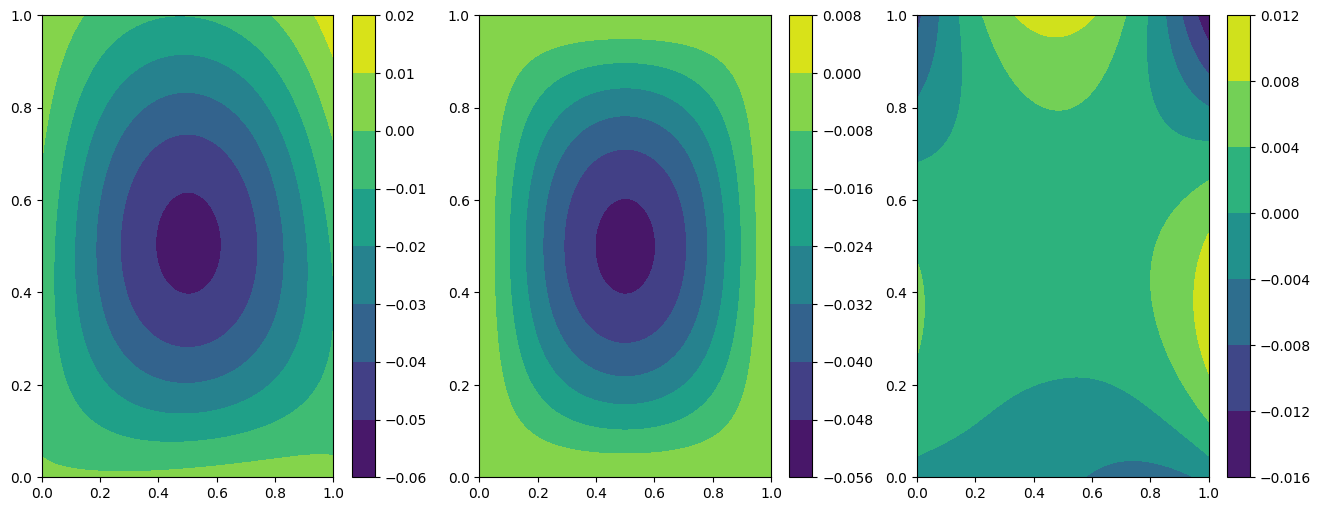

In [5]:
plotter = Plotter()
plotter.plot(pinn)

### The problem solution with extra features

We can solve the problem above a different way.
We define a new neural network, with an additional parameter `extra_features`, which contains the forcing term in the Laplace equation. 
And so, the set of the neural network's input variables is:

\begin{equation}
[x, y, k(x, y)], \text{ with } k(x, y)=\sin{(\pi x)}\sin{(\pi y)},
\end{equation}

where $x$ and $y$ are the spatial coordinates and $k(x, y)$ is the added feature. 

This feature is initialized in the class `SinSin`, which needs to inherit the `torch.nn.Module` class and have the `forward` method. The rest of the code is then similar to above, except with the additional `extra_features` argument.
**NB**: `extra_features` always needs a `list` as input, even if you only include one additional feature, as in the example below.

Note that we perform the same training as before: the problem is still `Poisson`, the network is composed by the same number of neurons, and the optimizer parameters are equal to that of the previous test. The only change is the `extra_feature`.

In [6]:
class SinSin(torch.nn.Module):
    """Feature: sin(x)*sin(y)"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        t = (torch.sin(x.extract(['x'])*torch.pi) *
             torch.sin(x.extract(['y'])*torch.pi))
        return LabelTensor(t, ['sin(x)sin(y)'])

model_feat = FeedForward(
        layers=[10, 10],
        output_variables=problem.output_variables,
        input_variables=problem.input_variables,
        func=Softplus,
        extra_features=[SinSin()]
    )

pinn_feat = generate_samples_and_train(model_feat, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 8.334048e-02 1.480584e-02 1.326940e-02 1.505190e-02 1.282023e-02 2.739312e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 2.369340e-02 1.785535e-03 1.441936e-03 1.978278e-03 1.193302e-03 1.729435e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.190661e-05 5.259407e-06 2.207154e-06 1.740728e-06 1.258537e-06 3.144078e-05 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 2.964181e-06 3.873027e-08 3.952280e-08 6.926503e-08 4.859637e-08 2.768067e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 2.477657e-06 3.019578e-08 3.888974e-08 5.290904e-08 4.751930e-08 2.308143e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

The predicted solution, the exact solution, and the error between them are represented below left to right.
Note that now our network, having a stronger features than before, is able to reach an additional order of magnitude in accuracy.

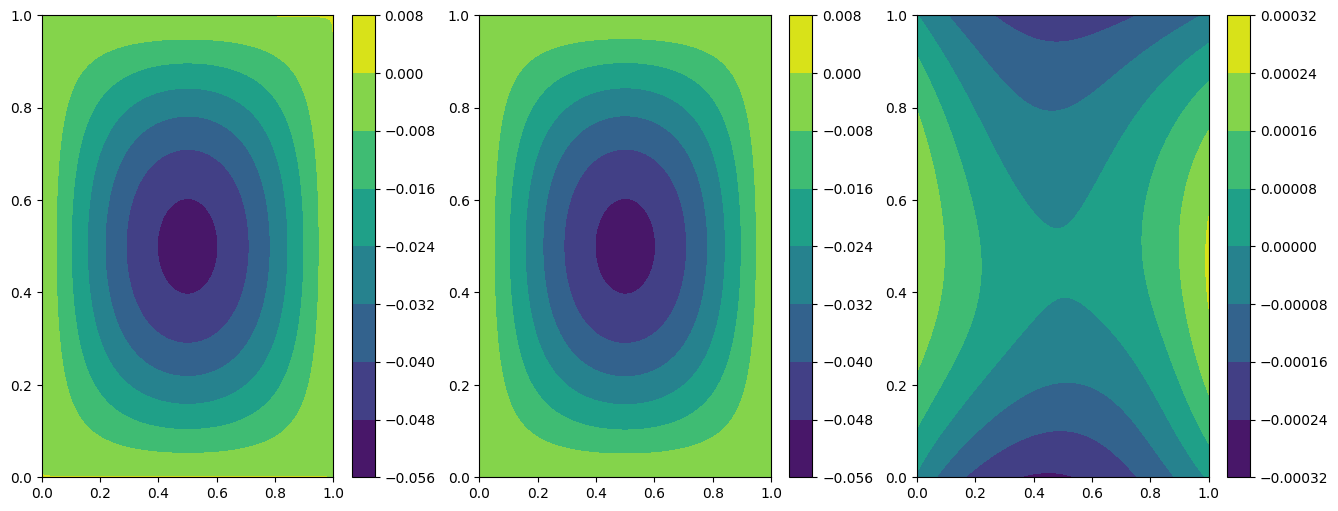

In [7]:
plotter.plot(pinn_feat)

### The problem solution with learnable extra features

We can still do better!

Another way to exploit the `extra_features` is to add a learnable parameter.
These added parameters are learned during the neural network's training phase. In this case, we will use:

\begin{equation}
k(x, \mathbf{y}) = \beta \sin{(\alpha x)} \sin{(\alpha y)},
\end{equation}

where $\alpha$ and $\beta$ are the parameters.
Their implementation is quite trivial: by using the class `torch.nn.Parameter`, we can define all the learnable parameters we need, and the `autograd` manages all of them!

In [8]:
class SinSinAB(torch.nn.Module):
    """ """
    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.tensor([1.0]))


    def forward(self, x):
        t = (
            self.beta*torch.sin(self.alpha*x.extract(['x'])*torch.pi)*
                      torch.sin(self.alpha*x.extract(['y'])*torch.pi)
        )
        return LabelTensor(t, ['b*sin(a*x)sin(a*y)'])


model_learn = FeedForward(
    layers=[10, 10],
    output_variables=problem.output_variables,
    input_variables=problem.input_variables,
    extra_features=[SinSinAB()]
)

pinn_learn = generate_samples_and_train(model_learn, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 3.918677e-01 2.501913e-02 1.278682e-02 1.963722e-02 1.756839e-02 3.168561e-01 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 1.345929e-01 1.696471e-02 9.475741e-03 1.432935e-02 1.169397e-02 8.212914e-02 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.500092e-04 1.441140e-05 9.839978e-06 2.283052e-05 4.087769e-06 3.988396e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 2.102947e-04 1.462936e-05 2.168394e-06 4.655578e-06 4.340448e-07 1.884074e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 1.371512e-04 1.072066e-05 1.284032e-06 2.897264e-06 1.126986e-06 1.211222e-04 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

The final loss is not appreciably better than the previous model (with static extra features), despite using learnable parameters. This is mainly due to the over-parametrization of the network: there are many parameter to optimize during the training, and the model in unable to understand automatically that only the parameters of the extra feature (and not the weights/bias of the FFN) should be tuned in order to fit our problem. A longer training can be helpful, but in this case, the faster way to reach machine precision for solving the Poisson problem is removing all the hidden layers in the `FeedForward`, keeping only the $\alpha$ and $\beta$ parameters of the extra feature, as illustrated below.

In [9]:
model_learn = FeedForward(
    layers=[],
    output_variables=problem.output_variables,
    input_variables=problem.input_variables,
    extra_features=[SinSinAB()]
)

pinn_learn = generate_samples_and_train(model_learn, problem)

              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00000] 1.974945e+00 2.002993e-03 7.012323e-02 2.755559e-02 1.584911e-02 1.859414e+00 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00001] 1.761779e+00 3.188374e-03 6.539153e-02 2.452723e-02 1.474262e-02 1.653930e+00 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00100] 4.036187e-03 1.676370e-05 2.384196e-05 1.675912e-05 2.528631e-05 3.953536e-03 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00200] 3.638973e-06 9.148435e-09 5.011525e-09 8.995231e-09 5.055353e-09 3.610763e-06 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamma4nil_di Dlaplace_equ 
[epoch 00300] 7.258809e-11 2.040413e-13 1.323202e-13 1.966580e-13 1.385408e-13 7.191653e-11 
              sum          gamma1nil_di gamma2nil_di gamma3nil_di gamm

Now, the model is able to reach a very high accuracy!
Of course, this is a toy problem for understanding the usage of extra features: similar precision could be obtained if the extra features are very similar to the true solution.

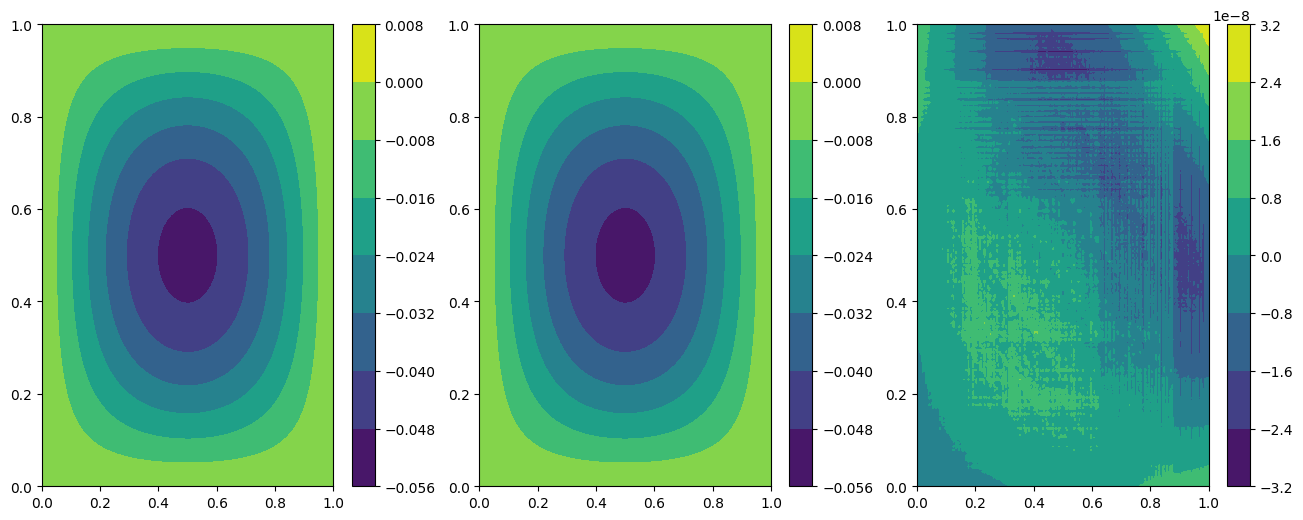

In [10]:
plotter.plot(pinn_learn)

Below is a graphical comparison of the unknown field and the loss trend for all the test cases presented here: the standard PINN, PINN with extra features, and PINN with learnable extra features.

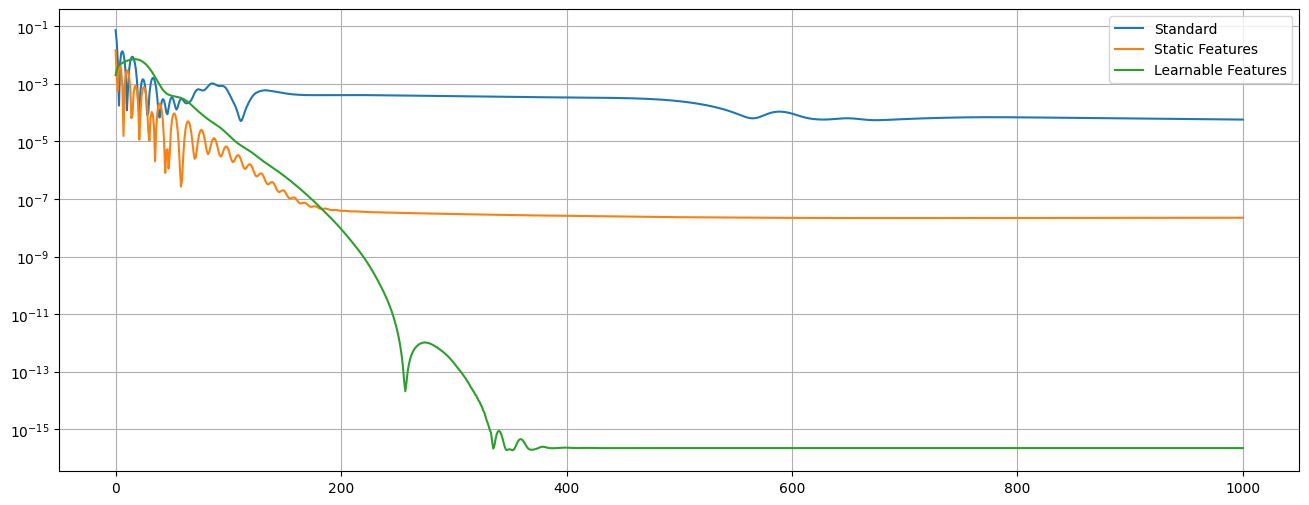

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plotter.plot_loss(pinn, label='Standard')
plotter.plot_loss(pinn_feat, label='Static Features')
plotter.plot_loss(pinn_learn, label='Learnable Features')

plt.grid()
plt.legend()
plt.show()